# Attack trends

##  (Optional) Setup root directory

## Install requirements

Install the python packages (`pip install -r requirements.txt`). We recommend using the python virtual environment.

In [ ]:
!pip3 install -r requirements.txt

In [53]:
# import libraries
import json
import psycopg2
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from web3 import Web3
from web3.middleware import ExtraDataToPOAMiddleware

## Helper Functions & Definitions for Ethereum Analysis

In [42]:
def block_to_time(block_number, w3):
    """
    Convert a block number to utc timestamp.
    """
    block = w3.eth.get_block(int(block_number))
    return block.timestamp

def bucket_to_time_range(bucket_start, bucket_end, w3):
    """
    Convert a block bucket (start, end) to human-readable datetime range.
    """
    start_time = block_to_time(bucket_start, w3)
    end_time = block_to_time(bucket_end, w3)
    return (start_time, end_time)

In [38]:
RPC_URL = "https://ethereum-rpc.publicnode.com"
w3_eth = Web3(Web3.HTTPProvider(RPC_URL))
print(f"Is connected: {w3_eth.is_connected()}")

Is connected: True


## Load eth payoff data & test helper functions
Dataset provided by Tsuchiya et al. pulls data from November 2022 to July 2024

In [43]:
# Path to your CSV
ETH_PATH = "/Users/vlad/Downloads/GitHub/ethereum-poisoning-detector/data/payoff_transfers_ethereum.csv"

# Read CSV
payoff_transfers_eth = pd.read_csv(ETH_PATH)

# Ensure block_number is integer
payoff_transfers_eth['block_number'] = payoff_transfers_eth['block_number'].astype(int)

# Get min/max block numbers
min_block = int(payoff_transfers_eth['block_number'].min())
max_block = int(payoff_transfers_eth['block_number'].max())
print(f"min block height: {min_block}, max block height: {max_block}")
start_time, end_time = bucket_to_time_range(min_block, max_block, w3_eth)
print(f"Blockheight date range: {datetime.utcfromtimestamp(start_time)} → {datetime.utcfromtimestamp(end_time)}")

min block height: 16060625, max block height: 20207365
Blockheight date range: 2022-11-27 10:07:59 → 2024-06-30 22:02:59


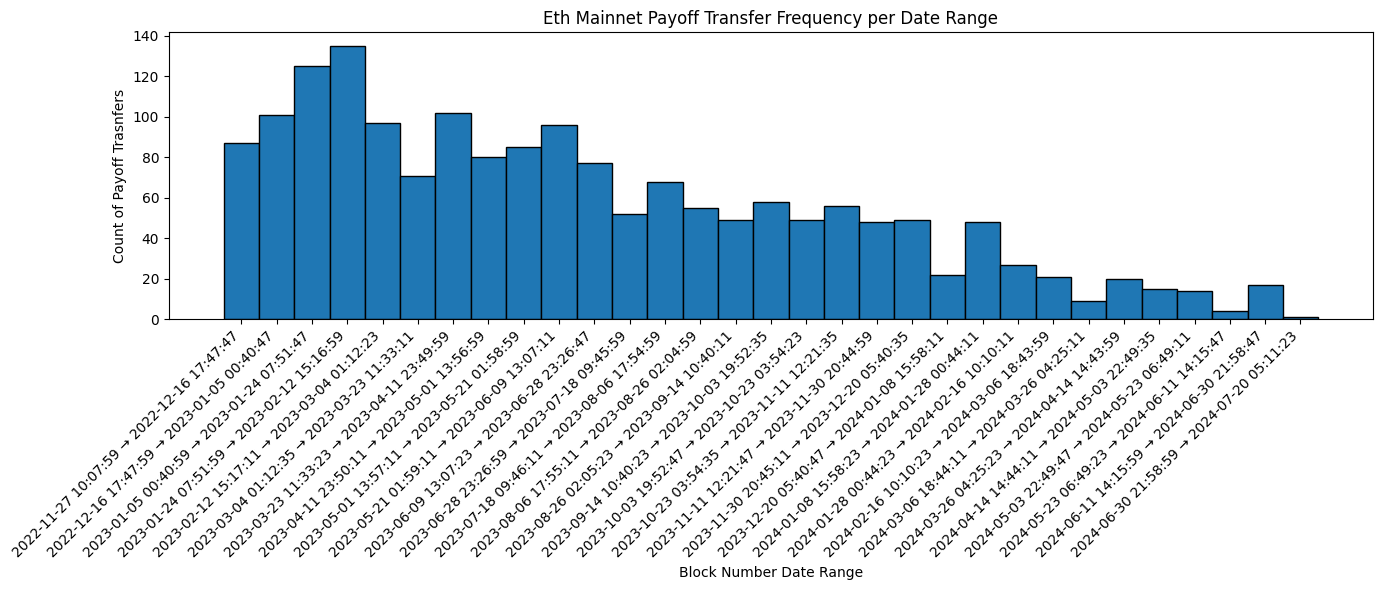

In [45]:
# Automatic bucket size (roughly 20 buckets)
num_buckets = 30
bucket_size = max(1, (max_block - min_block) // num_buckets)
bins = np.arange(min_block, max_block + bucket_size, bucket_size)

# Compute human-readable labels for each bin
bin_labels = [
    f"{datetime.utcfromtimestamp(start)} → {datetime.utcfromtimestamp(end)}"
    for start, end in (
        bucket_to_time_range(int(bins[i]), int(bins[i + 1] - 1), w3_eth)
        for i in range(len(bins) - 1)
    )
]

# Plot histogram
plt.figure(figsize=(14,6))
plt.hist(payoff_transfers_eth['block_number'], bins=bins, edgecolor='black')
plt.title("Eth Mainnet Payoff Transfer Frequency per Date Range")
plt.xlabel("Block Number Date Range")
plt.ylabel("Count of Payoff Trasnfers")
plt.xticks(ticks=bins[:-1] + bucket_size/2, labels=bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Ethereum attackers 

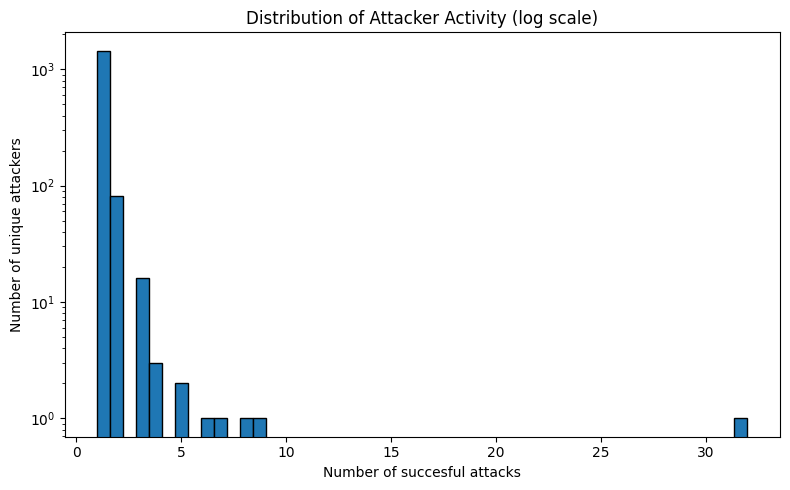

In [61]:
# Count how many times each attacker (topics_to_addr) appears
attacker_counts = payoff_transfers_eth['topics_to_addr'].value_counts()

# Plot histogram of those counts
plt.figure(figsize=(8, 5))
plt.hist(attacker_counts, bins=50, edgecolor='black', log=True)
plt.xlabel('Number of succesful attacks')
plt.ylabel('Number of unique attackers')
plt.title('Distribution of Attacker Activity (log scale)')
plt.tight_layout()
plt.show()


In [62]:
# Count how many times each attacker address appears
attacker_counts = payoff_transfers_eth['topics_to_addr'].value_counts()

# Get the top 10 attackers
top_attackers = attacker_counts.head(10)

# Print results
print("Top 10 attackers by number of occurrences:\n")
for rank, (address, count) in enumerate(top_attackers.items(), start=1):
    print(f"{rank}. {address} — {count} occurrences")

Top 10 attackers by number of occurrences:

1. 0xedEa5c9611ebA47998C9C245Bc0Eb212FC8A2DCe — 32 occurrences
2. 0xe5AB17098506A1Be492E948C9A9b3B7A9bD35DD5 — 9 occurrences
3. 0xdAA744760E4ad8C5C4773d1f84913d59Ea141855 — 8 occurrences
4. 0x23c22839503eF2165d75be41Ff17906b83CfBaBF — 7 occurrences
5. 0x946C8e51D95A1f1643c3617363aeE83439f98Cd6 — 6 occurrences
6. 0x95008eCb751EbC8C8a667f9D5688849CB74066a2 — 5 occurrences
7. 0xF689570e7e0D10A01844e94d612ab2562C402525 — 5 occurrences
8. 0x79396c1e60bf1aD60cDBc61e50589f460E21A251 — 4 occurrences
9. 0xf337A2A4C87C173ec625659Df2F2Ab749dEd265F — 4 occurrences
10. 0x03A84bE9ce3d8918f29A7B4653a8FcfB9Cc0483D — 4 occurrences


## Helper Functions & Definitions for Binance Analysis

In [56]:
BSC_RPC = "https://bsc-dataseed.binance.org/" 
w3_bsc = Web3(Web3.HTTPProvider(BSC_RPC))
w3_bsc.middleware_onion.inject(ExtraDataToPOAMiddleware, layer=0)
print("Connected:", w3_bsc.is_connected())
print("Chain ID:", w3_bsc.eth.chain_id)  # Should be 56 for BSC mainnet

Connected: True
Chain ID: 56


In [57]:
# Path to your CSV
BSC_PATH = "/Users/vlad/Downloads/GitHub/ethereum-poisoning-detector/data/payoff_transfers_bsc.csv"

# Read CSV
payoff_transfers_bsc = pd.read_csv(BSC_PATH)

# Ensure block_number is integer
payoff_transfers_bsc['block_number'] = payoff_transfers_bsc['block_number'].astype(int)

# Get min/max block numbers
min_block = int(payoff_transfers_bsc['block_number'].min())
max_block = int(payoff_transfers_bsc['block_number'].max())
print(f"min block height: {min_block}, max block height: {max_block}")
start_time, end_time = bucket_to_time_range(min_block, max_block, w3_bsc)
print(f"Blockheight date range: {datetime.utcfromtimestamp(start_time)} → {datetime.utcfromtimestamp(end_time)}")

min block height: 22853528, max block height: 40071926
Blockheight date range: 2022-11-07 15:19:58 → 2024-06-30 19:16:02


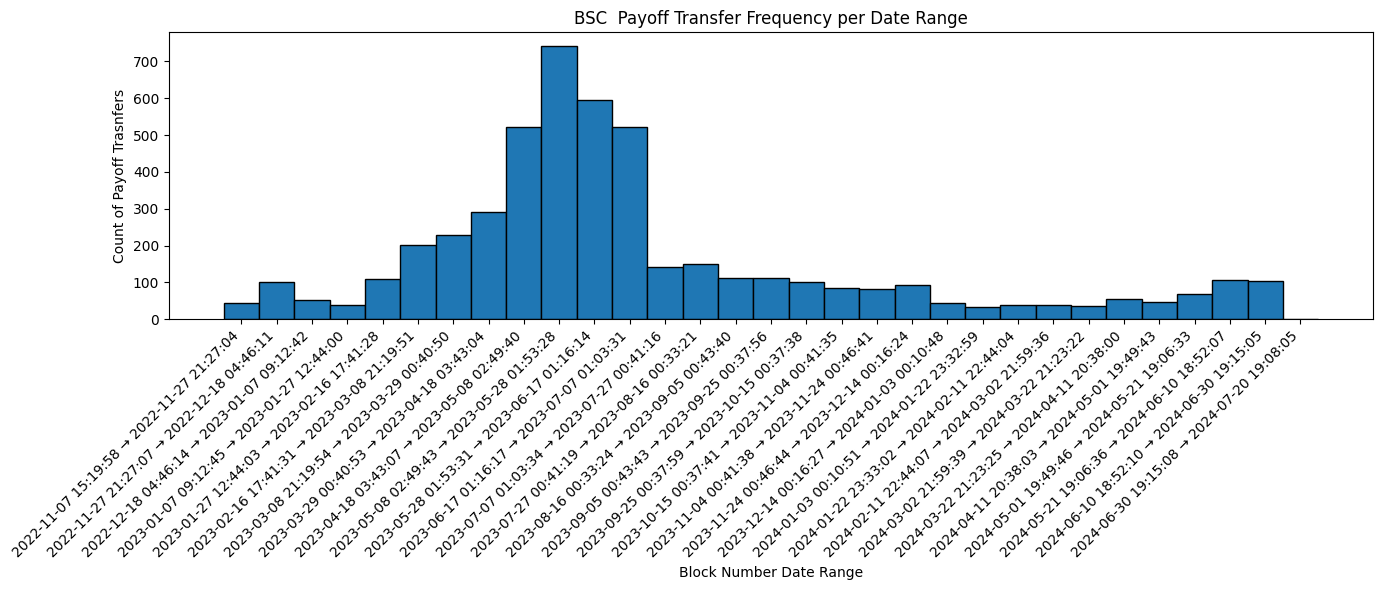

In [59]:
# Automatic bucket size (roughly 20 buckets)
num_buckets = 30
bucket_size = max(1, (max_block - min_block) // num_buckets)
bins = np.arange(min_block, max_block + bucket_size, bucket_size)

# Compute human-readable labels for each bin
bin_labels = [
    f"{datetime.utcfromtimestamp(start)} → {datetime.utcfromtimestamp(end)}"
    for start, end in (
        bucket_to_time_range(int(bins[i]), int(bins[i + 1] - 1), w3_bsc)
        for i in range(len(bins) - 1)
    )
]

# Plot histogram
plt.figure(figsize=(14,6))
plt.hist(payoff_transfers_bsc['block_number'], bins=bins, edgecolor='black')
plt.title("BSC  Payoff Transfer Frequency per Date Range")
plt.xlabel("Block Number Date Range")
plt.ylabel("Count of Payoff Trasnfers")
plt.xticks(ticks=bins[:-1] + bucket_size/2, labels=bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# save your PostgreSQL credentials in postgre.json file
try:
    with open("./postgre.json", "r", encoding="latin-1") as credential:
        json_credential = json.load(credential)

except FileNotFoundError:
    print("Please create a postgre.json file with your PostgreSQL credentials.")
    print("The file should contain the following keys: host, database, username, password.")
    print('{"host": "localhost", "database": "your_database_name", "username": "your_username", "password": "your_password"}')
    exit()

HOST = json_credential["host"]
DATABASE = json_credential["database"]
USERNAME = json_credential["username"]
PASSWORD = json_credential["password"]

# connect to your database
conn = psycopg2.connect(database=DATABASE, user=USERNAME, host="localhost", password=PASSWORD)
c = conn.cursor()
print('Successfully connected to the database')

db_name = json_credential["table"]

Successfully connected to the database


## Dataset (address_poisoning_ethereum)
Each data entry corresponds to one of token transfers related to address poisoning on Ethereum: intended, tiny, zero-value, counterfeit token, and payoff transfers.
The description and the type of each column is in the table below.

| Column | Type | Description |
|--------|------|-------------|
| block_number | integer | The block number of the transfer |
| tx_hash | character(66) | The transaction hash of the transfer |
| addr | character(42) | The address of the token transferred |
| topics_from_addr | character(42) | The sender |
| topics_to_addr | character(42) | The receiver |
| is_sender_victim | boolean | True if the sender is a victim |
| value | real | The value transferred |
| value_usd | real | The value converted to USD at the time of the transfer |
| intended_transfer | boolean | True if the transfer is an intended transfer |
| tiny_transfer | boolean | True if the transfer is a tiny transfer |
| zero_value_transfer | boolean | True if the transfer is a zero-value transfer |
| counterfeit_token_transfer | boolean | True if the transfer is a counterfeit token transfer |
| payoff_transfer | boolean | True if the transfer is a payoff transfer (confirmed) |
| payoff_transfer_unconfirmed | boolean | True if the transfer is potentially a payoff transfer (more investigation required) |
| is_not_categorized | boolean | True if the transfer is not labeled for any categories |
| intended_addr | character(42) | The intended address of the transfer |
| num_first_matched_digits | integer | The number of first matched digits |
| num_last_matched_digits | integer | The number of last matched digits |

Remarks
- `payoff_transfer` does not represent all the payoff transfers we captured. We confirm each transfer in `payoff_transfer_unconfirmed` on Etherscan to check if the poisoning transfer exists between the intended and the payoff transfer. Alternatively, you can find the final results in `payoff_transfers_ethereum.csv`.
- Most of the uncategorized transfers (is_not_categorized transfers=True) are tiny transfers that exceed the threshold (>=10 USD). There are only 8,651 out of 34,905,969 (0.025%).
- The number of matched first (last) digits is the number of matched digits between the lookalike address and the intended address. For the intended transfer, it would be (20, 20).

In [ ]:
# basic connection
conn.rollback()         # clear the aborted transaction
c.execute(f"SELECT * FROM {db_name} LIMIT 10;")
results = c.fetchall()
print(results[5])


(16582469, '0x31042594fce5088cfbdbc8b2e56f52a53cf9422f69552dd26eac02f3d702d8e4', '0xdAC17F958D2ee523a2206206994597C13D831ec7', '0xBC952257C0469125C6328A1d39d785805dc6849d', '0x61e0675505c5af10aE335E73C14aAA0f455Ee382', True, 16093270.0, 16.09327, True, False, False, False, False, False, False, '0x61e0675505c5af10aE335E73C14aAA0f455Ee382', 20, 20)
